I've approached this problem as a regression problem and trained the model with the helps of LSTMs, details of the model architecture are furnished below.

I've evaluated the model using 3 iterations of hold-out validation, the details of which are furnished below

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np

In [2]:
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [12]:
#Please mount it to appropriate directory where all the files are put
cd gdrive/My\ Drive/73Strings

/content/gdrive/My Drive/73Strings


In [ ]:
#Constructing dataframe using dictionary.txt and sentiment_labels.txt
phrase_and_ids = pd.read_table('dictionary.txt',delimiter='|',names=['Phrase', 'PhraseID'])
ids_and_labels = pd.read_table('sentiment_labels.txt',delimiter='|',names=['PhraseID', 'Labels'],header=0)
df_all = phrase_and_ids.merge(ids_and_labels, how='inner', on='PhraseID')

In [ ]:
#Glimpse of the dataset
df_all

,Phrase,PhraseID,Labels
0,!,0,0.50000
1,! ',22935,0.52778
2,! '',18235,0.50000
3,! Alas,179257,0.44444
4,! Brilliant,22936,0.86111
...,...,...,...
239227,zoning ordinances to protect your community fr...,220441,0.13889
239228,zzzzzzzzz,179256,0.19444
239229,élan,220442,0.51389
239230,É,220443,0.50000


In [ ]:
#Estimating the maximum length of phrases.
length_phrases = []

for index, row in df_all.iterrows():
  sentence = (row['Phrase'])
  sentence_words = sentence.split(' ')
  len_sentence_words = len(sentence_words)
  length_phrases.append(len_sentence_words)
max_length_of_a_phrase = max(length_phrases)

In [ ]:
# Creating a dictionary that maps a word to its embedding(100 dimensional)
#Used GloVe embeddings
embeddings_index = dict()
f = open('glove_6B_100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word.lower()] = coefs
f.close()

In [8]:
#Transforming list of phrases, such that from each phrase special characters(mentioned below in filter param) are removed, 
# and words are encoded, and finally the phrase is padded to max_length_of_a_phrase
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


t = Tokenizer(filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'')
t.fit_on_texts(df_all.iloc[:,0])
encoded_docs = t.texts_to_sequences(df_all.iloc[:,0])
max_length = max_length_of_a_phrase
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


In [ ]:
vocab_size = len(t.word_index) + 1

In [ ]:
#Constructing the embedding_matrix which maps the encoded words to its respective word embeddings
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
	embedding_vector = embeddings_index.get(word.lower())
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
#Performing 3 iterations of hold-out validation to assess the model
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(
    padded_docs, df_all.loc[:,'Labels'], test_size=0.20, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    padded_docs, df_all.loc[:,'Labels'], test_size=0.20, random_state=43)
X_train3, X_test3, y_train3, y_test3 = train_test_split(padded_docs, df_all.loc[:,'Labels'], test_size=0.20, random_state=44)

In [ ]:
#I've experimented with various architectures, the model architecture which is given below is the best one among them.
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dropout



model = Sequential()
e = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_length_of_a_phrase, trainable=False)
model.add(e)
#model.add(Flatten())
model.add(LSTM(512))
model.add(Dropout(0.30))
model.add(Dense(200,activation='relu'))
model.add(Dropout(0.30))
model.add(Dense(100, activation='relu'))
model.add(Dense(1,activation='relu'))

model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])
# summarize the model
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 56, 100)           1806000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               1255424   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               102600    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [ ]:
history = model.fit(X_train3, y_train3, epochs=20,validation_data=(X_test3,y_test3),batch_size=128)

Epoch 1/20
1496/1496 [==============================] - 35s 23ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.1194 - val_loss: 0.0174 - val_mse: 0.0174 - val_mae: 0.0972
Epoch 2/20
1496/1496 [==============================] - 35s 23ms/step - loss: 0.0164 - mse: 0.0164 - mae: 0.0948 - val_loss: 0.0155 - val_mse: 0.0155 - val_mae: 0.0922
Epoch 3/20
1496/1496 [==============================] - 35s 23ms/step - loss: 0.0143 - mse: 0.0143 - mae: 0.0886 - val_loss: 0.0136 - val_mse: 0.0136 - val_mae: 0.0869
Epoch 4/20
1496/1496 [==============================] - 35s 23ms/step - loss: 0.0128 - mse: 0.0128 - mae: 0.0838 - val_loss: 0.0138 - val_mse: 0.0138 - val_mae: 0.0871
Epoch 5/20
1496/1496 [==============================] - 35s 23ms/step - loss: 0.0116 - mse: 0.0116 - mae: 0.0797 - val_loss: 0.0119 - val_mse: 0.0119 - val_mae: 0.0796
Epoch 6/20
1496/1496 [==============================] - 35s 23ms/step - loss: 0.0106 - mse: 0.0106 - mae: 0.0762 - val_loss: 0.0127 - val_mse: 0.0127 - val_mae:

In [13]:
#I've already trained the model for all 3 iterations of hold-out validation, and have stored the model and the corresponding history files.
# So that it can be loaded later
import keras
import pickle as pkl
model1 = keras.models.load_model('model_new_1.0')
model2 = keras.models.load_model('model_new_2.0')
model3 = keras.models.load_model('model_new_3.0')

with open('history_new_1.0.pkl','rb') as file1:
  hist_1 = pkl.load(file1)
with open('history_new_2.0.pkl','rb') as file1:
  hist_2 = pkl.load(file1)
with open('history_new_3.0.pkl','rb') as file1:
  hist_3 = pkl.load(file1)

In [15]:
#We see the average performance of the model across 3 runs of hold-out validation
mean_mae = (hist_1['val_mae'][-1]+hist_2 ['val_mae'][-1]+hist_3['val_mae'][-1])/3
mean_mse = (hist_1['val_mse'][-1]+hist_2['val_mse'][-1]+hist_3['val_mse'][-1])/3
print("The performance of the model architecture across three runs of hold out validation is : \n Validation_MSE: %f \t Validation_MAE: %f " %(mean_mse,mean_mae))

The performance of the model architecture across three runs of hold out validation is : 
 Validation_MSE: 0.009434 	 Validation_MAE: 0.071322 


In [14]:
#We see the average performance of the model across 3 runs of hold-out validation
mean_mae = (hist_1['mae'][-1]+hist_2 ['mae'][-1]+hist_3['mae'][-1])/3
mean_mse = (hist_1['mse'][-1]+hist_2['mse'][-1]+hist_3['mse'][-1])/3
print("The performance of the model architecture across three runs of hold out validation is : \n Train_MSE: %f \t Train_MAE: %f " %(mean_mse,mean_mae))

The performance of the model architecture across three runs of hold out validation is : 
 Train_MSE: 0.005045 	 Train_MAE: 0.052639 


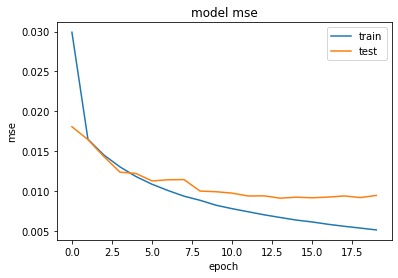

In [19]:
#Plotting the history file(MSE) of model1, for visualization purpose
import matplotlib.pyplot as plt
plt.plot(hist_1['mse'])
plt.plot(hist_1['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

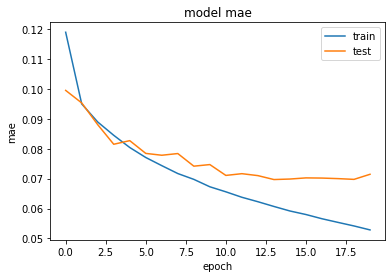

In [20]:
#Plotting the history file(MAE) of model1, for visualization purpose
import matplotlib.pyplot as plt
plt.plot(hist_1['mae'])
plt.plot(hist_1['val_mae'])
plt.title('model mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()